#English

## 1. Introduction



In this project, an Exploratory Data Analysis (EDA) and a time series-based sales prediction model were performed using a dataset available at this [link](https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales) from Kaggle.

The primary objective of this project is to understand historical sales patterns and develop a machine learning model capable of anticipating future behavior to provide valuable insights for decision-making.

The workflow included the following key stages:

1. **Data Extraction from Kaggle using an API**:
    The Kagglehub API was used to extract the data correctly and ensure it remains updated if there are changes to the data source.

2. **Exploratory Data Analysis (EDA)**:
    Python and libraries such as pandas, matplotlib, and seaborn were utilized to clean and analyze the dataset, identify trends, seasonality, and key variables affecting sales, as well as to quickly visualize the data.

3. **Predictive Modeling with Machine Learning**:
    The Prophet forecasting model developed by Facebook was implemented to predict future sales, taking into account trends and seasonal events.

4. **Visualization in Power BI**:
    The data and results obtained were integrated into an interactive Power BI dashboard, enabling the communication of insights in a visual and intuitive manner.

This project aims to demonstrate technical skills in data analysis, predictive modeling, and the creation of dynamic visualizations, as well as the ability to work with modern data science tools and business analytics. This approach is essential for extracting value from data and supporting evidence-based decision-making.

## 2. Project Development

This section will detail step by step the process followed to develop the sales analysis and prediction, from setting up the environment and preparing the data to implementing the model and the final visualization.

### Importing Libraries

The first step was to import the necessary libraries to carry out the analysis and modeling. Standard Python tools widely recognized in the data science community were used, along with data visualization tools, the Kagglehub library for data extraction, and Prophet for model development.

In [1]:
# Libraries for data manipulation, handling, and analysis
import pandas as pd
import numpy as np

# Library for data extraction from Kaggle
import kagglehub
import os

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for the time series model
from prophet import Prophet
from prophet.diagnostics import performance_metrics

# Handling warnings
import warnings
warnings.filterwarnings("ignore")

# Configuring the style of visualizations
plt.style.use('seaborn-v0_8-dark')

### Data Extraction

To ensure the analysis is based on up-to-date information, the Kagglehub library was used to download the data directly from Kaggle. This approach enables a dynamic and flexible workflow, as the information can be easily synchronized if updates to the dataset occur.

In [2]:
# The dataset is downloaded from Kaggle
path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# Name of the downloaded file
file_name = "Coffee Shop Sales.xlsx"

# The full file path is constructed
file_path = os.path.join(path, file_name)

# The file is loaded into a pandas DataFrame
coffee_sales = pd.read_excel(file_path)

100%|██████████| 8.23M/8.23M [00:00<00:00, 63.3MB/s]

Extracting files...


### Exploratory Data Analysis (EDA)

Once the data is loaded into a DataFrame, it is essential to perform an initial exploration to understand its structure and data quality. Using the info() method, we get an overview of the data, showing key information about its structure.

In [3]:
coffee_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


We can see that the data is organized by a transaction identifier, accompanied by important details such as the transaction date, quantity sold, store location, and product features, such as unit price, category, and type. Additionally, there are a total of 149,116 rows, and most importantly, none of them contain missing data. An additional point to note is that the date and time of the transaction are separated into different columns.

### Transforming the Date and Time Columns

Since the transaction date and time are in separate columns (`transaction_date` and `transaction_time`), the goal of this step is to combine them into a single column with a timestamp format (date and time) to facilitate temporal analysis.

In [4]:
# The 'transaction_date' and 'transaction_time' columns are concatenated into a single column called 'transaction_timestamp'
# First, both columns are converted to string (str) type and joined with a space in between
coffee_sales["transaction_timestamp"] = coffee_sales["transaction_date"].astype(str) + ' ' + coffee_sales["transaction_time"].astype(str)

# The new 'transaction_timestamp' column is converted to datetime type for easier temporal analysis
coffee_sales["transaction_timestamp"] = pd.to_datetime(coffee_sales["transaction_timestamp"])

# The original 'transaction_date' and 'transaction_time' columns are dropped
coffee_sales.drop(["transaction_date", "transaction_time"], axis=1, inplace=True)

To verify that the new column is correct, we can check the data by displaying the first few rows and ensuring that the transaction_timestamp column contains the expected datetime format.

In [5]:
coffee_sales["transaction_timestamp"].head()

,transaction_timestamp
0,2023-01-01 07:06:11
1,2023-01-01 07:08:56
2,2023-01-01 07:14:04
3,2023-01-01 07:20:24
4,2023-01-01 07:22:41


### Verification of Duplicate Transactions

To ensure that each transaction is unique, we compare the total number of records in the dataset with the number of unique identifiers in the `transaction_id` column. If both values are equal, it means there are no duplicate transactions; otherwise, there are duplicate records in the data.

In [6]:
# Remove duplicate values in the 'transaction_id' column and count the number of unique identifiers
unique_transactions = coffee_sales["transaction_id"].drop_duplicates().shape[0]

# Count the total number of rows in the original DataFrame
total_transactions = coffee_sales.shape[0]

# Compare if the number of unique identifiers is equal to the total number of rows in the DataFrame
# If True, each transaction has a unique identifier, meaning there are no duplicates
# If False, some transactions share the same 'transaction_id', indicating duplicates
unique_transactions == total_transactions

True

### Detailed Verification of Store Locations

To analyze the distribution of transactions per store, the following code counts the frequency of each unique combination of `store_location` and `store_id`. This helps identify how many transactions were recorded at each store and detect potential inconsistencies in the data, such as stores with multiple identifiers or duplicate locations.

In [7]:
# Count the frequency of unique combinations of 'store_location' and 'store_id'
coffee_sales[["store_location", "store_id"]].value_counts()

,,count
store_location,store_id,
Hell's Kitchen,8,50735
Astoria,3,50599
Lower Manhattan,5,47782


The result displays the number of transactions recorded for each `store_location` and `store_id` combination. For example, the store in *Hell’s Kitchen* with ID **8** had **50,735** transactions, while the one in *Astoria* with ID **3** recorded **50,599** sales. Similarly, the store in *Lower Manhattan* with ID **5** accumulated **47,782** transactions.

### Normalization of Values in Product Details

To ensure data consistency in the `product_detail` column, we need to check for inconsistencies such as variations in uppercase and lowercase letters, extra spaces between words, or leading and trailing spaces.

To achieve this, we will compare the number of unique values in the dataset before and after normalizing the text by removing extra spaces and converting all text to lowercase.

In [8]:
# Print the number of unique values before validation
print(f"Number of unique values before validation: {coffee_sales['product_detail'].value_counts().shape[0]}")

# Print the number of unique values after applying validation (normalizing spaces, converting to lowercase, and stripping)
print("Number of unique values after validation: ",
      coffee_sales['product_detail'].str.replace(r'\s+', ' ', regex=True).str.lower().str.strip().value_counts().shape[0])


Number of unique values before validation: 80
Number of unique values after validation:  80


Since the number of unique values remained the same before and after normalization, we can conclude that these data do not require corrections.

### Checking for Outliers in Unit Prices

To check for outliers in the unit prices, we can generate a box plot, which visually represents the distribution of the values. This plot will help us identify any extreme values that may exist outside the interquartile range (IQR).

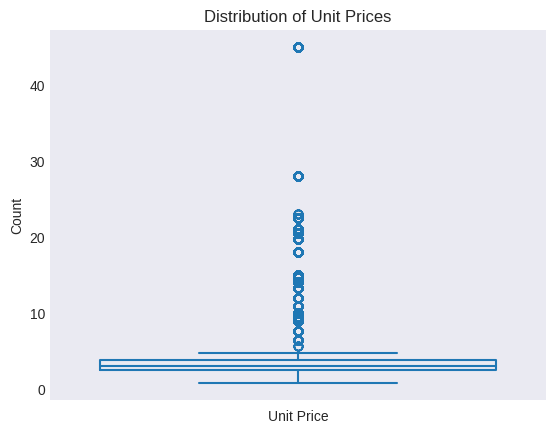

In [9]:
# Generate the box plot for the 'unit_price' column
sns.boxplot(coffee_sales["unit_price"], fill=False)
plt.title("Distribution of Unit Prices")
plt.ylabel("Count")
plt.xlabel("Unit Price")
# Call show() to display the plot
plt.show()


To investigate the prices exceeding $25, we can filter the corresponding records and check which products have these extreme prices.

In [10]:
# Filter products with a unit price greater than or equal to 25 dollars and group by quantity
coffee_sales[coffee_sales["unit_price"] >= 25]["product_type"].value_counts()

,count
product_type,
Clothing,216
Premium Beans,190
Organic Beans,17


In [11]:
# Filter products with a unit price greater than or equal to 25 and with product type "Clothing"
# Then, get the unique values in the 'product_detail' column
coffee_sales[(coffee_sales["unit_price"] >= 25) & (coffee_sales["product_type"] == "Clothing")]["product_detail"].unique()

array(['I Need My Bean! T-shirt'], dtype=object)

It's clear that the high-priced products are premium and organic coffee bean bags, as well as clothing items with the store's branding.

For the next step, let's investigate the minimum prices in the store.

In [12]:
# Get the minimum value of the unit price in the "unit_price" column
coffee_sales["unit_price"].min()

0.8


To find out which category and product type corresponds to the minimum price of $0.80, you can filter the dataset based on the minimum price.

In [13]:
# Filter products with a unit price of exactly 0.8 and count the number of products in each category
coffee_sales[coffee_sales["unit_price"] == 0.8]["product_category"].value_counts()


,count
product_category,
Flavours,6790


In [14]:
# Filter products with a unit price of 0.8 and product category "Flavours", then count by product type
coffee_sales[
    (coffee_sales["unit_price"] == 0.8)
    &
    (coffee_sales["product_category"] == "Flavours")
]["product_type"].value_counts()

,count
product_type,
Regular syrup,4979
Sugar free syrup,1811


As we can see, syrups are the products with the minimum price in the store, costing $0.80. This suggests that the syrups in the "Flavours" category are the least expensive items in the dataset.

### Visual Analysis of the Dataset

#### Categories

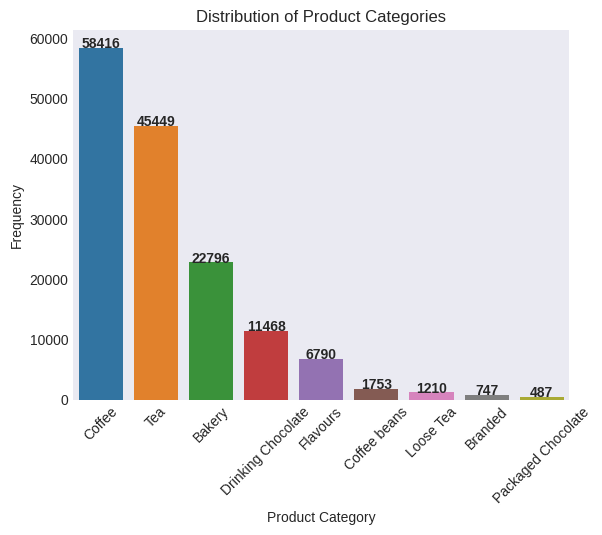

In [15]:
# Count the number of products in each category and reset the index to structure it as a DataFrame
product_category_count = coffee_sales["product_category"].value_counts().reset_index()

# Create a bar chart with Seaborn
ax = sns.barplot(
    x=product_category_count["product_category"],  # Product category on the X-axis
    y=product_category_count["count"],  # Frequency on the Y-axis
    hue=product_category_count["product_category"],  # Color by category
)

# Add numerical labels above each bar for better value visualization
for i, value in enumerate(product_category_count["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Add title and labels to the axes
plt.title("Distribution of Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Frequency")

# Rotate X-axis labels for better visibility
plt.xticks(rotation=45)

# Show the chart
plt.show()


In order to interpret the distribution and corresponding percentages, a function will be declared to calculate the percentages of the total accumulated sales.


In [16]:
def percentage_category(category, df, column, total):
    """
    Calculates the percentage of a specific category within a Pandas DataFrame.

    Args:
        category: The value to search for in the specified column.
        df: The Pandas DataFrame to search within.
        column: The name of the column to search in.
        total: The total value to calculate the percentage against.

    Returns:
        The percentage of the category rounded to 2 decimal places, or an error
        message if the DataFrame is invalid or unprocessed.
    """
    try:
        value = df[df[column] == category]["count"].values[0]
        return round((value / total) * 100, 2)
    except:
        return "invalid or unprocessed dataframe"

In [17]:
# Define a list with the product categories to analyze
product_category = [
    "Bakery",              # Baked goods
    "Packaged Chocolate",  # Packaged chocolates
    "Coffee",              # Coffee
    "Tea",                 # Tea
    "Branded"              # Branded products
]

# Calculate the total number of products in all categories by summing the frequencies
total_categories = product_category_count.sum().values[1]

In [18]:
# Iterate over each product category in the product_category list
for cat in product_category:
    # Calculate the sales percentage of the current category and display the result
    print(f"{cat}: {percentage_category(cat, product_category_count, 'product_category', total_categories)} % of total sales")

Bakery: 15.29 % of total sales
Packaged Chocolate: 0.33 % of total sales
Coffee: 39.17 % of total sales
Tea: 30.48 % of total sales
Branded: 0.5 % of total sales


This graph shows us the distribution of cafeteria sales by product category. We can see that the products in the Coffee and Tea categories dominate total sales, which indicates that these products are the customers' favorites. Coffee makes up almost two-fifths of total sales, with a specific figure of 39.17% of total sales, and tea has 30.48% of corresponding sales. Baked goods are in third place, representing 15.29% of total sales, which, despite being a secondary category, represents an important part of the revenue.

Among the products with the lowest sales, we can see that packaged chocolates represent just 0.33% of total sales, followed by products with the store logo at 0.5% of accumulated sales.


#### Types

In [ ]:
# Calculate the total number of unique product types in the dataset
len(coffee_sales["product_type"].unique())

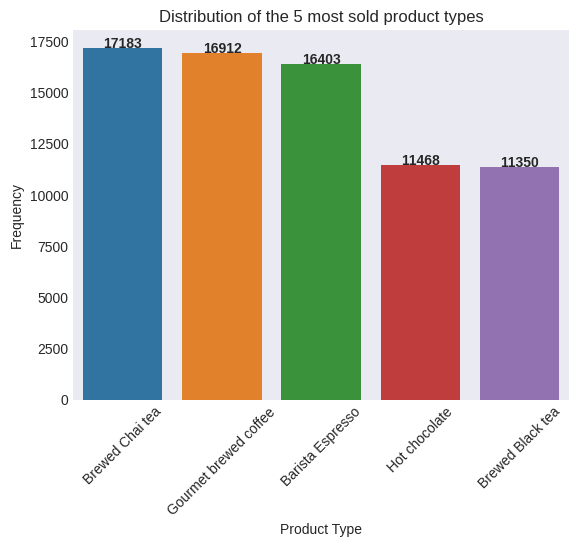

In [19]:
# Count the number of products in each Type and reset the index to structure it as a DataFrame
product_type_count_top5 = coffee_sales["product_type"].value_counts().reset_index().head()

# Create a bar chart with Seaborn
ax = sns.barplot(
    x=product_type_count_top5["product_type"],  # Product type on the X-axis
    y=product_type_count_top5["count"],  # Frequency on the Y-axis
    hue=product_type_count_top5["product_type"],  # Color by Type
)

# Add numerical labels above each bar for better value visualization
for i, value in enumerate(product_type_count_top5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Add title and labels to the axes
plt.title("Distribution of the 5 most sold product types")
plt.xlabel("Product Type")
plt.ylabel("Frequency")

# Rotate X-axis labels for better visibility
plt.xticks(rotation=45)

# Show the chart
plt.show()


#Español

##1. Introducción


En este proyecto, se realizó un análisis exploratorio de datos (EDA) y un modelo de predicción de ventas basado en series temporales usando un conjunto de datos disponible en este [enlace](https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales) de Kaggle.

El Objetivo principal de este proyecto es comprender los patrones históricos de ventas y poder desarrollar un modelo de aprendizaje automático que pueda anticipar el comportamiento futuro para poder proporcionar información valiosa para para la toma de decisiones.

El flujo de trabajo incluyó las siguientes etapas principales:


1.   **Extracción de los datos de Kaggle usando una Api**:
    Se uso la API Kagglehub para poder extraer los datos de manera correcta y poder mantenerlos actualizados si existe un cambio en el origen de los datos.
2.   **Análisis Exploratorio de Datos (EDA)**:
    Se utilizó Python y bibliotecas como pandas, matplotlib y seaborn para limpiar y analizar el conjunto de datos, identificando tendencias, estacionalidad y variables clave que afectan las ventas, así como para visualizar los datos de manera rápida.
3. **Modelado Predictivo de aprendizaje automatico**:
    Se implementó el modelo de pronóstico Prophet desarrollado por Facebook para predecir ventas futuras, considerando aspectos como tendencias y eventos estacionales.
4. **Visualización en Power BI**:
    Los datos y resultados obtenidos se integraron en un tablero interactivo en Power BI, facilitando la comunicación de insights de manera visual e intuitiva.

El proyecto busca demostrar habilidades técnicas en análisis de datos, modelado predictivo y creación de visualizaciones dinámicas, así como la capacidad de trabajar con herramientas modernas de ciencia de datos y análisis empresarial. Este enfoque es crucial para extraer valor de los datos y apoyar la toma de decisiones basadas en evidencia.



## 2. Desarrollo del proyecto

En esta sección, se detallará paso a paso el proceso seguido para desarrollar el análisis y la predicción de las ventas, desde la configuración del entorno y la preparación de los datos, hasta la implementación del modelo y la visualización final.

### Importación de las librerías

El primer paso fue importar las librerías necesarias para llevar a cabo el análisis y modelado. Se utilizaron herramientas estándar de Python que son ampliamente reconocidas en la comunidad de ciencia de datos, así como herramientas de visualización de datos, la libería de Kagglehub para la extracción de los datos y Prophet, para el desarrollo del modelo.

In [20]:
# Librerías para la manipulación, manejo  y análisis de datos
import pandas as pd
import numpy as np

# Librería para extracción de datos desde Kaggle
import kagglehub
import os

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para el modelo basado en series temporales
from prophet import Prophet
from prophet.diagnostics import performance_metrics

# Manejo de advertencias
import warnings
warnings.filterwarnings("ignore")

# Configuración del estilo de las visualizaciones
plt.style.use('seaborn-v0_8-dark')


### Extracción de los Datos

Para garantizar que el análisis se base en información al día, se utilizó la librería kagglehub para descargar los datos directamente desde Kaggle, esto permite tener un enfoque en un flujo de trabajo dinámico y flexible, ya que la información se puede sincronizar fácilmente en caso de existir actualizaciones en el conjunto de datos.

In [21]:
# Se descarga el conjunto de datos desde Kaggle
path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# Nombre del archivo descargado
file_name = "Coffee Shop Sales.xlsx"

# Se construye la ruta completa del archivo
file_path = os.path.join(path, file_name)

# Se carga el archivo a un DataFrame de pandas.
coffee_sales = pd.read_excel(file_path)

### Análisis Exploratorio de Datos (EDA)

Una vez cargados los datos en un DataFrame, es fundamental realizar una exploración inicial para comprender su estructura y calidad de los datos usando el método info(), este nos proporciona una vista general de los datos para ver información clave sobre la estructura de los datos.

In [22]:
coffee_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


Podemos ver que los datos están organizados por un identificador de transacción, el cual está acompañado de información importante como la fecha de la transacción, la cantidad vendida, la ubicación de la tienda y características del producto, como su precio unitario, categoría y tipo.
Además de estos detalles, se cuenta con un total de 149,116 filas, y lo más relevante es que ninguna de ellas contiene datos nulos. Un aspecto adicional a destacar es que la fecha y la hora de la transacción están separadas en columnas distintas.



### Transformación de las columnas de fecha y hora

Dado que la fecha y la hora de la transacción se encuentran separadas en columnas distintas (`transaction_date` y `transaction_time`), el objetivo de este paso es combinarlas en una sola columna con un formato de timestamp (fecha y hora) para facilitar el análisis temporal.

In [23]:
# Se concadenan las columnas 'transaction_date' y 'transaction_time' en una sola columna llamada 'transaction_timestamp'
# Primero, se convierte ambas columnas a tipo cadena (str) y se unen con un espacio en medio
coffee_sales["transaction_timestamp"] = coffee_sales["transaction_date"].astype(str) + ' ' + coffee_sales["transaction_time"].astype(str)

# Se convierte la columna nueva 'transaction_timestamp' a tipo datetime para facilitar el análisis temporal
coffee_sales["transaction_timestamp"] = pd.to_datetime(coffee_sales["transaction_timestamp"])

# Se eliminan las columnas originales 'transaction_date' y 'transaction_time'
coffee_sales.drop(["transaction_date", "transaction_time"], axis=1, inplace=True)

Para verificar que la nueva columna es correcta, podemos comprobar los datos mostrando las primeras filas y asegurándonos de que la columna transaction_timestamp contiene el formato datetime esperado.


In [24]:
coffee_sales["transaction_timestamp"].head()

,transaction_timestamp
0,2023-01-01 07:06:11
1,2023-01-01 07:08:56
2,2023-01-01 07:14:04
3,2023-01-01 07:20:24
4,2023-01-01 07:22:41


### Verificación de duplicados en las transacciones

Para asegurarnos de que cada transacción es única, se compara el número de registros originales del conjunto de datos con el número de identificadores únicos en la columna `transaction_id`. Si ambos valores son iguales, significa que no hay transacciones duplicadas; de lo contrario, existen registros repetidos en los datos.



In [25]:
# Eliminar valores duplicados en la columna 'transaction_id' y contar cuántos identificadores únicos existen
unique_transactions = coffee_sales["transaction_id"].drop_duplicates().shape[0]

# Contar el número total de filas en el DataFrame original
total_transactions = coffee_sales.shape[0]

# Comparar si el número de identificadores únicos es igual al número total de filas en el DataFrame
# Si es True, significa que cada transacción tiene un identificador único y no hay duplicados
# Si es False, significa que existen transacciones con el mismo 'transaction_id' más de una vez
unique_transactions == total_transactions

True

### Verificación de las ubicaciones de las tiendas

Para analizar la distribución de las transacciones por tienda, el siguiente código cuenta la frecuencia de ocurrencia de cada combinación única de `store_location` y `store_id`. Esto permite identificar cuántas transacciones se realizaron en cada tienda y detectar posibles inconsistencias en los datos, como tiendas con múltiples identificadores o ubicaciones duplicadas.

In [26]:
# Contar la frecuencia de combinaciones únicas de 'store_location' y 'store_id'
coffee_sales[["store_location", "store_id"]].value_counts()


,,count
store_location,store_id,
Hell's Kitchen,8,50735
Astoria,3,50599
Lower Manhattan,5,47782


El resultado muestra el número de transacciones registradas en cada combinación de `store_location` y `store_id`. Por ejemplo, la tienda en *Hell’s Kitchen* con el ID **8** tuvo **50,735** transacciones, mientras que la ubicada en *Astoria* con el ID **3** registró **50,599** ventas. De manera similar, la tienda en *Lower Manhattan* con el ID **5** acumuló **47,782** transacciones.

### Normalización de valores en los detalles de los productos

Para verificar que el conjunto de datos no tenga incosistencias en la columna `product_detail`, como pueden ser las variaciones en las mayúsculas o minúsculas, espacios adicionales en medio de las oraciones, al principio o final de estas.

Para lograr esto, se va a comparar el tamaño del dataset filtrado por valores únicos antes y después de una normalización de los datos eliminando los espacios extras, asi como convirtiendo el texto a minúsculas.

In [27]:
# Imprimir el número de valores únicos antes de la validación
print(f"Numero de valores antes de la validación: {coffee_sales['product_detail'].value_counts().shape[0]}")

# Imprimir el número de valores únicos después de aplicar la validación (normalización de espacios, minúsculas y strip)
print("Numero de valores después de la validación: ",
      coffee_sales['product_detail'].str.replace(r'\s+', ' ', regex=True).str.lower().str.strip().value_counts().shape[0])



Numero de valores antes de la validación: 80
Numero de valores después de la validación:  80


Como la cantidad de valores únicos se mantuvo igual antes y después de la normalización, podemos concluir que estos datos no requieren correcciones.



### Revisar si no hay valores extremos en los precios unitarios

Para poder revisar si hay valores extremos en los precios unitarios, se ejecutara un codigo que nos permita generar un gráfico de caja para poder ver visualmente la distribución de los valores. Este gráfico nos ayudará a identificar los valores extremos que puedan existir fuera del rango intercuartílico (IQR).

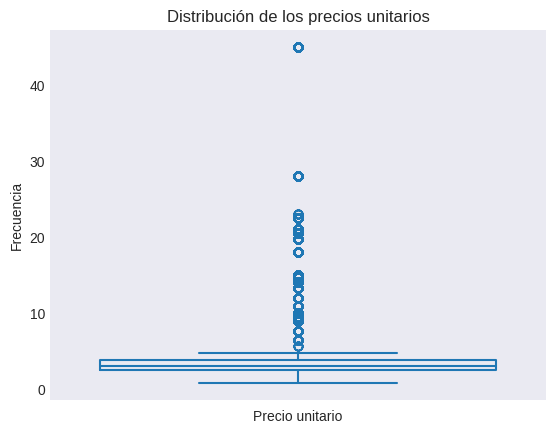

In [28]:
#Se genera el gráfico con la columna unit_price
sns.boxplot(coffee_sales["unit_price"], fill=False)
plt.title("Distribución de los precios unitarios")
plt.xlabel("Precio unitario")
plt.ylabel("Frecuencia")
#se llama show() para mostrar el gráfico
plt.show()

Podemos ver en el gráfico precios que sobrepasan los $25 doláres, para investigarlo vamos a ejecutar el siguente código.

In [29]:
# Filtrar los productos cuyo precio unitario es mayor o igual a 25 doláres y agrupar por cantidad.
coffee_sales[coffee_sales["unit_price"]>=25]["product_type"].value_counts()

,count
product_type,
Clothing,216
Premium Beans,190
Organic Beans,17


In [30]:
# Filtrar los productos cuyo precio unitario es mayor o igual a 25 y cuyo tipo de producto es "Clothing"
# Y  obtener los valores únicos
coffee_sales[(coffee_sales["unit_price"]>=25)&(coffee_sales["product_type"]== "Clothing")]["product_detail"].unique()

array(['I Need My Bean! T-shirt'], dtype=object)

Podemos ver que estos productos con precios altos son bolsas de granos de café premium y orgánicos, así como piezas de ropa con el branding de la tienda.

Para el siguiente paso se van a investigar los precios mínimos de la tienda.

In [31]:
# Obtener el valor mínimo del precio unitario en la columna "unit_price"
coffee_sales["unit_price"].min()

0.8

Podemos ver un precio mínimo de $0.8 doláres, para ver a que categoría y tipo de producto, se va a ejecutar el siguiente código.

In [32]:
# Se van a filtrar los productos cuyo precio unitario es exactamente 0.8
# y se van a contar la cantidad de productos en cada categoría.
coffee_sales[coffee_sales["unit_price"]==0.8]["product_category"].value_counts()

,count
product_category,
Flavours,6790


In [33]:
# Filtrar los productos cuyo precio unitario es 0.8 y cuya categoría de producto es "Flavours" y contar por categoria
coffee_sales[
    (coffee_sales["unit_price"]==0.8)
    &
    (coffee_sales["product_category"]== "Flavours")
    ]["product_type"].value_counts()

,count
product_type,
Regular syrup,4979
Sugar free syrup,1811


Como podemos ver, los jarabes son los productos con el precio mínimo en la tienda con un costo de $0.8 doláres.

### Exploración visual del conjunto de datos

#### Categorías

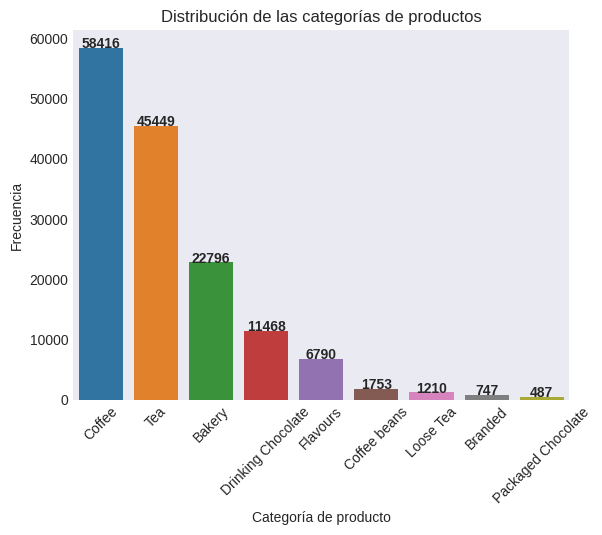

In [34]:
# Contar la cantidad de productos en cada categoría y reiniciar el índice para estructurarlo en un DataFrame
product_category_count = coffee_sales["product_category"].value_counts().reset_index()

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    x=product_category_count["product_category"],  # Categoría de producto en el eje X
    y=product_category_count["count"],  # Frecuencia en el eje Y
    hue=product_category_count["product_category"],  # Colorear por categoría
)

# Agregar etiquetas numéricas encima de cada barra para visualizar mejor los valores
for i, value in enumerate(product_category_count["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Agregar título y etiquetas a los ejes
plt.title("Distribución de las categorías de productos")
plt.xlabel("Categoría de producto")
plt.ylabel("Frecuencia")

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

Para poder interpretrar la distribución y los porcentajes correspondientes, se declará una función que nos permita calcular los porcentajes del total de las ventas acomuladas.

In [35]:
def percentage_category(category, df, column, total):
    """
    Calcula el porcentaje de una categoría específica dentro de un DataFrame de Pandas.

    Args:
        category: El valor a buscar en la columna especificada.
        df: El DataFrame de Pandas en el que se buscará.
        column: El nombre de la columna en la que se buscará.
        total: El valor total contra el que se calculará el porcentaje.

    Returns:
        El porcentaje de la categoría redondeado a 2 decimales, o un mensaje de error
        si el DataFrame no es válido o no ha sido procesado.
    """
    try:
        value = df[df[column] == category]["count"].values[0]
        return round((value / total) * 100, 2)
    except:
        return "dataframe no válido o no procesado"

In [36]:
# Definir una lista con las categorías de productos a analizar
product_category = [
    "Bakery",              # Productos horneados
    "Packaged Chocolate",  # Chocolates empaquetados
    "Coffee",              # Café
    "Tea",                 # Té
    "Branded"              # Productos de marca
]

# Calcular el total de productos en todas las categorías sumando las frecuencias
total_categories = product_category_count.sum().values[1]

In [37]:
# Iterar sobre cada categoría de producto en la lista product_category
for cat in product_category:
    # Calcular el porcentaje de ventas de la categoría actual y mostrar el resultado
    print(f"{cat}: {percentage_category(cat, product_category_count, 'product_category', total_categories)} % del total de las ventas")


Bakery: 15.29 % del total de las ventas
Packaged Chocolate: 0.33 % del total de las ventas
Coffee: 39.17 % del total de las ventas
Tea: 30.48 % del total de las ventas
Branded: 0.5 % del total de las ventas


Este gráfico nos muestra la distribución de las ventas de la cafetería por categoría de producto, podemos ver que los productos de las categorías *Coffee y Tea* dominan en las ventas totales, lo cuál nos indica que estos productos son los productos favoritos de los clientes, siendo el café casi dos quintas partes del total de las ventas, teniendo un dato especifico del 39.17% de las ventas totales, y el té tiene un 30.48% de las ventas correspondientes. Los productos horneados se encuentran en tercer lugar, siendo un 15.29% de las ventas totales, lo cuál a pesar de ser una categoría secundaria, representan una parte importante de los ingresos.


En los productos con menos ventas, podemos ver que los chocolates enpaquetados represetan apenas un 0.33% del total de las ventas, seguidos de los productos con el logo de la tienda con el 0.5% de las ventas acomuladas.

#### Tipos

In [47]:
# Calcular el número total de tipos de productos únicos en el conjunto de datos
len(coffee_sales["product_type"].unique())

29

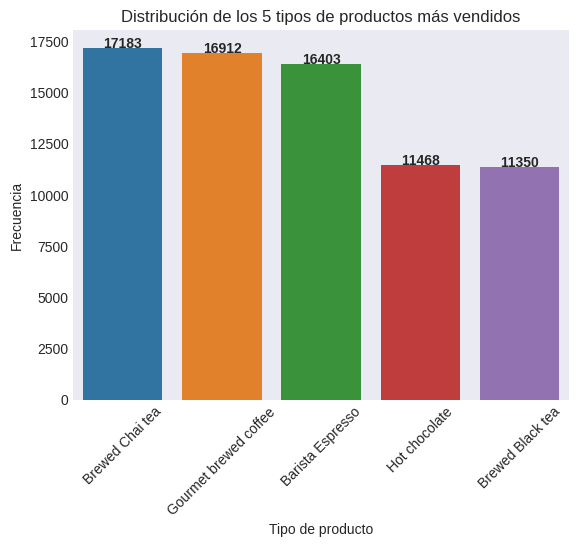

In [39]:
# Contar la cantidad de productos en cada Tipo y reiniciar el índice para estructurarlo en un DataFrame
product_type_count_top5 = coffee_sales["product_type"].value_counts().reset_index().head()

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    x=product_type_count_top5["product_type"],  # Tipo de producto en el eje X
    y=product_type_count_top5["count"],  # Frecuencia en el eje Y
    hue=product_type_count_top5["product_type"],  # Colorear por Tipo
)

# Agregar etiquetas numéricas encima de cada barra para visualizar mejor los valores
for i, value in enumerate(product_type_count_top5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Agregar título y etiquetas a los ejes
plt.title("Distribución de los 5 tipos de productos más vendidos")
plt.xlabel("Tipo de producto")
plt.ylabel("Frecuencia")

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

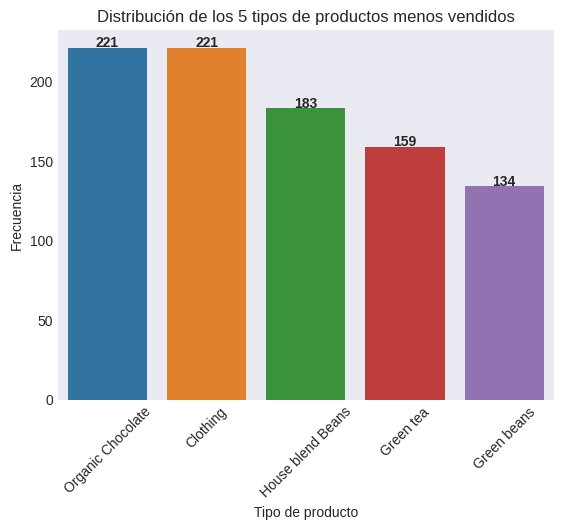

In [40]:
# Contar la cantidad de productos en cada Tipo y reiniciar el índice para estructurarlo en un DataFrame
product_type_count_bottom5 = coffee_sales["product_type"].value_counts().reset_index().tail()

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(
    x=product_type_count_bottom5["product_type"],  # Tipo de producto en el eje X
    y=product_type_count_bottom5["count"],  # Frecuencia en el eje Y
    hue=product_type_count_bottom5["product_type"],  # Colorear por Tipo
)

# Agregar etiquetas numéricas encima de cada barra para visualizar mejor los valores
for i, value in enumerate(product_type_count_bottom5["count"]):
    ax.text(i, value + 0.5, str(value), ha="center", fontsize=10, fontweight="bold")

# Agregar título y etiquetas a los ejes
plt.title("Distribución de los 5 tipos de productos menos vendidos")
plt.xlabel("Tipo de producto")
plt.ylabel("Frecuencia")

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

In [41]:
coffee_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   transaction_id         149116 non-null  int64         
 1   transaction_qty        149116 non-null  int64         
 2   store_id               149116 non-null  int64         
 3   store_location         149116 non-null  object        
 4   product_id             149116 non-null  int64         
 5   unit_price             149116 non-null  float64       
 6   product_category       149116 non-null  object        
 7   product_type           149116 non-null  object        
 8   product_detail         149116 non-null  object        
 9   transaction_timestamp  149116 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 11.4+ MB


In [42]:
coffee_sales["transaction_id"] = coffee_sales["transaction_id"].astype("category")
coffee_sales["store_id"] = coffee_sales["store_id"].astype("category")
coffee_sales["store_location"] = coffee_sales["store_location"].astype("category")
coffee_sales["product_id"] = coffee_sales["product_id"].astype("category")
coffee_sales["product_category"] = coffee_sales["product_category"].astype("category")
coffee_sales["product_type"] = coffee_sales["product_type"].astype("category")
coffee_sales["product_detail"] = coffee_sales["product_detail"].astype("category")
coffee_sales["transaction_qty"] = coffee_sales["transaction_qty"].astype("int16")
coffee_sales["unit_price"] = coffee_sales["unit_price"].astype("float32")
coffee_sales['transaction_timestamp'] = coffee_sales['transaction_timestamp'].astype('datetime64[s]')

In [43]:
coffee_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype        
---  ------                 --------------   -----        
 0   transaction_id         149116 non-null  category     
 1   transaction_qty        149116 non-null  int16        
 2   store_id               149116 non-null  category     
 3   store_location         149116 non-null  category     
 4   product_id             149116 non-null  category     
 5   unit_price             149116 non-null  float32      
 6   product_category       149116 non-null  category     
 7   product_type           149116 non-null  category     
 8   product_detail         149116 non-null  category     
 9   transaction_timestamp  149116 non-null  datetime64[s]
dtypes: category(7), datetime64[s](1), float32(1), int16(1)
memory usage: 8.6 MB
